Multiple distances

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *

In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(10 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [3]:
# mouse_vector = [56165, 56166, 32363, 32364, 32365, 32366, 411857]
# conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
# sessions_random = [4,1,1,0,2,3,2]
# sessions_overlapping = [1,2,2,1,3,0,3]
# sessions_stable = [2,0,0,2,0,0,1]

# for mouse in mouse_vector: 
#     for session_now in 
mouse = 56165 ### mouse number id
session_now = 1

file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'


objects_position_file = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/' + 'mouse_'+f'{mouse}'+'_session_'+f'{session_now}'+'.npy'
occupied_corners = np.load(objects_position_file)

In [4]:
task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)

activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list, day_list = load_data(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)
activity_list_trial,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list = load_data_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (397, 30905) beh shape(30905,)
LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (195, 32368) beh shape(32368,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (448, 30592) beh shape(30592,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,)
neural shape =  (322, 31977) beh shape(31977,

In [5]:
trial_list

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [6]:
print('APPLYING MULTIPLE DATA TRANSFORAMTION')
#data_transformation = transform_neural_data(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,trial_list)
data_transformation_trial = transform_neural_data(activity_list_trial, behaviour_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial,trial_list)

APPLYING MULTIPLE DATA TRANSFORAMTION


In [7]:
len(data_transformation_trial.pca)

20

In [8]:
print('CREATE TASK VECTOR')
create_task_behaviour(behaviour_list,colapse_behaviour,object_fixed,timeline_list)
create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_list_trial)

CREATE TASK VECTOR
REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [9]:
print('CREATING CORNERS VECTORS VECTORS')
navigation_list, exploration_list = create_corners_occupation(behaviour_list, corners_list, speed_list)
navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial)

CREATING CORNERS VECTORS VECTORS


In [10]:
combination_corners = []
combination_corners_trial = []
for i in range(len(navigation_list)):
    combination_corners.append(navigation_list[i] + exploration_list[i] )
for i in range(len(navigation_list_trial)):
    combination_corners_trial.append(navigation_list_trial[i] + exploration_list_trial[i])

In [11]:
id_target_combination = [1,2,3,4]
trial_activity, trial_activity_shuffle, distance = compute_representational_distance_measures_all_to_all(activity_list_trial,data_transformation_trial,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,trial_flag = True)

CREATE LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS
NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT
BALANCING TO THE LOWER NUMBER OF VISITS
CREATE SHUFFLE LABELS THAT PRESERVE BALANCE
[[24, 9, 21, 20], [10, 5, 18, 13], [17, 4, 20, 20], [11, 1, 30, 15], [17, 5, 9, 11], [19, 7, 20, 27], [16, 1, 13, 14], [7, 8, 11, 6], [5, 2, 13, 2], [8, 6, 18, 16], [9, 8, 12, 17], [18, 9, 27, 27], [18, 7, 16, 17], [5, 4, 19, 19], [9, 6, 4, 4], [17, 9, 7, 11], [9, 7, 7, 8], [3, 10, 27], [25, 4, 15, 9], [2, 6, 3, 1]]
TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that
CREATING VISITIS ACTIVITY MATRICES
CREATING DISTANCE tuple
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)


In [12]:
print(distance.cca_allo[0,:])


[ 0.          1.76559495  7.64558423  3.54425096  4.19369229  1.37095856
  0.94207574  2.22378054  6.27404822  2.24658071  1.52013685  2.87593119
  0.67987625 -2.99402888  3.44922505  2.92758404  2.44293602  2.39930169
  3.41730035  1.95432222  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [13]:
output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/distance_matrix/'
distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'.npy'
np.save(distance_matrix_file,distance)


## Analysis of distance matrix

[ 0.          2.92914592  1.09970049 -2.66286462  0.98750105 -1.14035443
 -0.19887267  0.71294867  0.18368999  0.72506767 -0.74057004 -0.88779367
 -0.81516722 -1.66015901 -0.65877065 -0.11991991 -0.06074943  1.33605181
 -0.1218458  -0.54489947  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


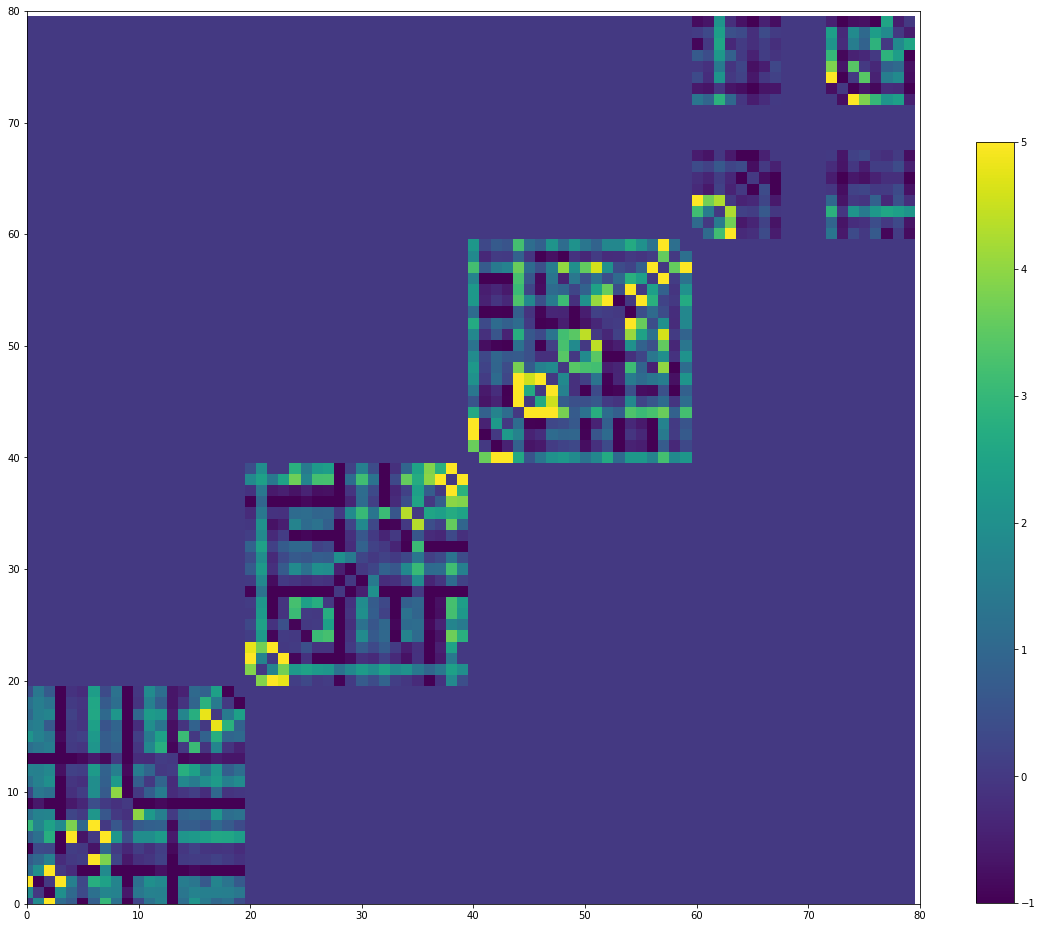

In [14]:
figure, axes = plt.subplots()
#dist = axes.imshow(np.nansum([distance.cca_time,distance.cca_time.T],axis = 0), vmin = -1, vmax = 20)
dist = axes.imshow(distance.neural, vmin = -1, vmax = 5)
figure.colorbar(dist, ax=axes, location='right', anchor=(0, 0.3), shrink=0.7)
figure.set_size_inches([20,20])
axes.set_xlim([0,80])
axes.set_ylim([0,80])

print(distance.cca_time[0,:])

In [16]:
all_corners = [1,2,3,4]
occupied_corners = occupied_corners.astype(int)
empty_corners = np.zeros((2,20))
for i in range(20):
    #intersection = list(set(all_corners) & set(occupied_corners[:,i]))
    #union = list(set(all_corners) | set(occupied_corners[:,i]))
    non_intersection = list(set(all_corners) ^ set(occupied_corners[:,i]))
    #non_intersection = list(intersection) - list(union)
    empty_corners[0,i] = non_intersection[0]
    empty_corners[1,i] = non_intersection[1]

occupancy_mask = np.zeros((4,20))
for i in range(20):
    occupancy_mask[occupied_corners[0,i]-1,i] = 1
    occupancy_mask[occupied_corners[1,i]-1,i] = 1
occupancy_mask = occupancy_mask.astype(bool)
#print(occupancy_mask)

index_corners_trial = np.zeros((4,2,20))
for corner in range(4):
    for day in range(4):
        for trial in range(5):
            i = day * 5 + trial
            if i < 19:
                index_corners_trial[corner,0,i] = int(day * 20 + trial * 4 + corner)
                index_corners_trial[corner,1,i] = int(day * 20 + (trial+1) * 4 + corner)      
index_corners_trial = index_corners_trial.astype(int)  

print(index_corners_trial)

distance_mean = mean_distance_occupancy_transformations(distance, index_corners_trial, occupancy_mask)

output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/occupancy/'
distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'.npy'
np.save(distance_matrix_file,distance_mean)

print(distance_mean)

[[[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72  0]
  [ 4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76  0]]

 [[ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73  0]
  [ 5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77  0]]

 [[ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74  0]
  [ 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78  0]]

 [[ 3  7 11 15 19 23 27 31 35 39 43 47 51 55 59 63 67 71 75  0]
  [ 7 11 15 19 23 27 31 35 39 43 47 51 55 59 63 67 71 75 79  0]]]
distance(neural=array([[ 0.19155677, -0.36770216,  0.99435437,  0.86743649],
       [ 0.5615487 ,  0.0177974 ,         nan,  1.16251779]]), pca=array([[ 2.28119606, -0.30171326,  1.02894052,  1.05748312],
       [ 0.94185776, -0.389672  ,         nan,  1.20191101]]), cca_time=array([[ 1.51252382, -0.13456448, -0.11865377, -0.04516221],
       [ 0.17361987, -0.12983623,         nan, -0.40573145]]), cca_allo=array([[ 1.93964947, -0.95417629,  2.51953633,  2.0945078 ],
       [ 

### End running point

In [17]:
index_obj1_obj2 = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        index_obj1_obj2[0,i] = int(occupied_corners[0,int(i/20)] + day * 20 + trial * 4 -1)
        index_obj1_obj2[1,i] = int(occupied_corners[1,int(i/20)] + day * 20 + trial * 4 -1)
index_obj1_obj2 = index_obj1_obj2.astype(int)

In [17]:
index_nav1_nav2 = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        index_nav1_nav2[0,i] = int(empty_corners[0,int(i/20)] + day * 20 + trial * 4 -1)
        index_nav1_nav2[1,i] = int(empty_corners[1,int(i/20)] + day * 20 + trial * 4 -1)
index_nav1_nav2= index_nav1_nav2.astype(int)

index_obj1_trial = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        if i < 19:
            index_obj1_trial[1,i] = int(occupied_corners[0,int(i/20)] + day * 20 + trial * 4 -1 )
            index_obj1_trial[0,i] = int(occupied_corners[0,int(i/20)] + day * 20 + (trial+1) * 4 -1)
index_obj1_trial = index_obj1_trial.astype(int)  
print(index_obj1_trial)

index_obj2_trial = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        if i < 19:
            index_obj2_trial[1,i] = int(occupied_corners[1,int(i/20)] + day * 20 + trial * 4 -1 )
            index_obj2_trial[0,i] = int(occupied_corners[1,int(i/20)] + day * 20 + (trial+1) * 4 -1)
index_obj2_trial = index_obj2_trial.astype(int)  
print(index_obj2_trial)

index_nav1_trial = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        if i < 19:
            index_nav1_trial[1,i] = int(empty_corners[0,int(i/20)] + day * 20 + trial * 4 -1 )
            index_nav1_trial[0,i] = int(empty_corners[0,int(i/20)] + day * 20 + (trial+1) * 4 -1)
index_nav1_trial = index_nav1_trial.astype(int)  
print(index_nav1_trial)

index_nav2_trial = np.zeros((2,20))
for day in range(4):
    for trial in range(5):
        i = day * 5 + trial
        if i < 19:
            index_nav2_trial[1,i] = int(empty_corners[1,int(i/20)] + day * 20 + trial * 4 -1 )
            index_nav2_trial[0,i] = int(empty_corners[1,int(i/20)] + day * 20 + (trial+1) * 4 -1)
index_nav2_trial = index_nav2_trial.astype(int)  
print(index_nav1_trial)


print('Hi')
print(index_corners_trial)

[[ 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78  0]
 [ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74  0]]
[[ 5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77  0]
 [ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73  0]]
[[ 4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76  0]
 [ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72  0]]
[[ 4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76  0]
 [ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72  0]]
Hi
[[[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72  0]
  [ 4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76  0]]

 [[ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73  0]
  [ 5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77  0]]

 [[ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74  0]
  [ 6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78  0]]

 [[ 3  7 11 15 19 23 27 31 35 39 43 47 51 55 59 63 67 71 75  0]
  [ 7 11 15 19 23 27 31 35 39 43 47

NameError: name 'index_obj1_obj2' is not defined

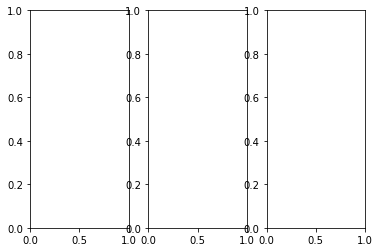

In [18]:
#plt.plot(distance.neural[index_1[0,:],index_1[1,:]])
distance_neural = np.nansum([distance.cca_allo,distance.cca_allo.T],axis = 0)

figure, axes = plt.subplots(1,3)
axes[0].plot(distance_neural[index_obj1_obj2[0,:],index_obj1_obj2[1,:]])
axes[0].plot(distance_neural[index_nav1_nav2[0,:],index_nav1_nav2[1,:]])
axes[0].axhline(y=0, color='k', linestyle='-')
axes[0].legend(['obj1-obj2','nav1-nav2'])


axes[1].plot(distance_neural[index_obj1_trial[0,:],index_obj1_trial[1,:]])
axes[1].plot(distance_neural[index_obj2_trial[0,:],index_obj2_trial[1,:]])
axes[1].plot(distance_neural[index_nav1_trial[0,:],index_nav1_trial[1,:]])
axes[1].plot(distance_neural[index_nav2_trial[0,:],index_nav2_trial[1,:]])
axes[1].legend(['ob1_t2t','ob2_t2t','nav1_t2t','nav2_t2t'])
axes[1].axhline(y=0, color='k', linestyle='-')

corners_distance = np.zeros((4,20))
for i in range(4):
    axes[2].plot(distance_neural[index_corners_trial[i,0,:],index_corners_trial[i,1,:]])
    corners_distance[i,:] = distance_neural[index_corners_trial[i,0,:],index_corners_trial[i,1,:]]
axes[2].legend(['c1','c2','c3','c4'])
    
axes[2].axhline(y=0, color='k', linestyle='-')


#for i in range(3):
#    axes[i].set_ylim([-6,20])

figure.set_size_inches([25,5])

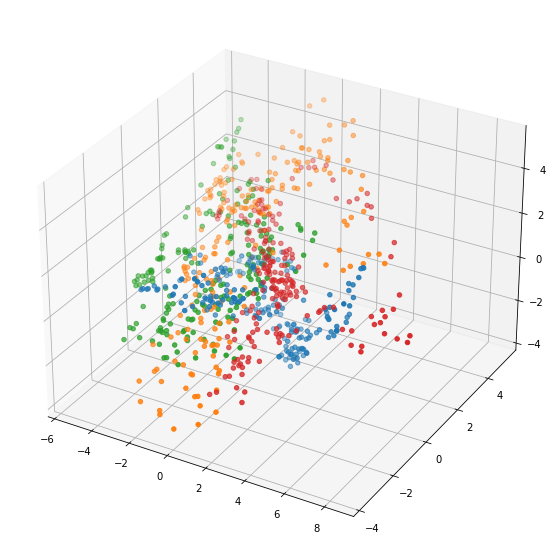

In [20]:
trial_activity.pca[3].shape


fig = plt.figure(figsize=(10,10))

axes = fig.add_subplot(111, projection='3d')

axes.scatter(trial_activity.pca[0][0,0,:],trial_activity.pca[0][0,1,:],trial_activity.pca[0][0,2,:])
axes.scatter(trial_activity.pca[0][1,0,:],trial_activity.pca[0][1,1,:],trial_activity.pca[0][1,1,:])
axes.scatter(trial_activity.pca[0][2,0,:],trial_activity.pca[0][2,1,:],trial_activity.pca[0][2,1,:])
axes.scatter(trial_activity.pca[0][3,0,:],trial_activity.pca[0][3,1,:],trial_activity.pca[0][3,1,:])

['LR', 'LL', 'UL', 'eLR', 'eLL', 'eUR', 'eUL']


NameError: name 'distance_combination' is not defined

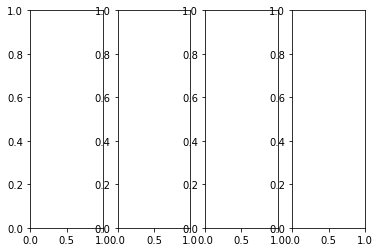

In [21]:
navigation_corners = ['LR','LL','UL']
object_corners = ['eLR','eLL','eUR','eUL']

conditions = ['LR','LL','UL','eLR','eLL','eUR','eUL']
print(conditions)
figure, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].imshow(distance_combination.neural[i], vmin = -2 , vmax = 10)
    axes[i].set_title('DAY = ' + str(i+1), fontsize = 18)

    x_pos = np.arange(len(conditions))
    axes[i].set_yticks(x_pos)
    axes[i].set_yticklabels(conditions)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(conditions)

    axes[i].set_ylabel('Conditions', fontsize = 15)
    axes[i].set_xlabel('Conditions', fontsize = 15)
    
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")  
    
    
figure.set_size_inches([20,5])

In [ ]:
navigation_corners = ['LR','LL','UL']
object_corners = ['eLR','eLL','eUR','eUL']

conditions = ['LR','LL','UL','eLR','eLL','eUR','eUL']
print(conditions)
figure, axes = plt.subplots(4,5)
for day in range(4):
    for trial in range(5):
        axes[day,trial].imshow(distance_combination_trial.lda[day*5+trial], vmin = -1 , vmax = 3)
        axes[day,trial].set_title('trial = ' + str(day*5+trial+1), fontsize = 18)

#     x_pos = np.arange(len(conditions))
#     axes[i].set_yticks(x_pos)
#     axes[i].set_yticklabels(conditions)
#     axes[i].set_xticks(x_pos)
#     axes[i].set_xticklabels(conditions)

#     axes[i].set_ylabel('Conditions', fontsize = 15)
#     axes[i].set_xlabel('Conditions', fontsize = 15)
    
#     plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")  
    
    
figure.set_size_inches([15,15])

In [22]:
interesting_pairs = [[0,1],[0,4],[3,4],[1,3]]

evolution1 = np.zeros((4,6,4))
for i in range(4):
    for j in range(len(interesting_pairs)):
        evolution1[j,0,i]=distance_combination.neural[i][interesting_pairs[j][0],interesting_pairs[j][1]]
        evolution1[j,1,i]=distance_combination.pca[i][interesting_pairs[j][0],interesting_pairs[j][1]]
        evolution1[j,2,i]=distance_combination.cca_time[i][interesting_pairs[j][0],interesting_pairs[j][1]]
        evolution1[j,3,i]=distance_combination.cca_allo[i][interesting_pairs[j][0],interesting_pairs[j][1]]
        evolution1[j,4,i]=distance_combination.cca_ego[i][interesting_pairs[j][0],interesting_pairs[j][1]]
        evolution1[j,5,i]=distance_combination.lda[i][interesting_pairs[j][0],interesting_pairs[j][1]]



NameError: name 'distance_combination' is not defined

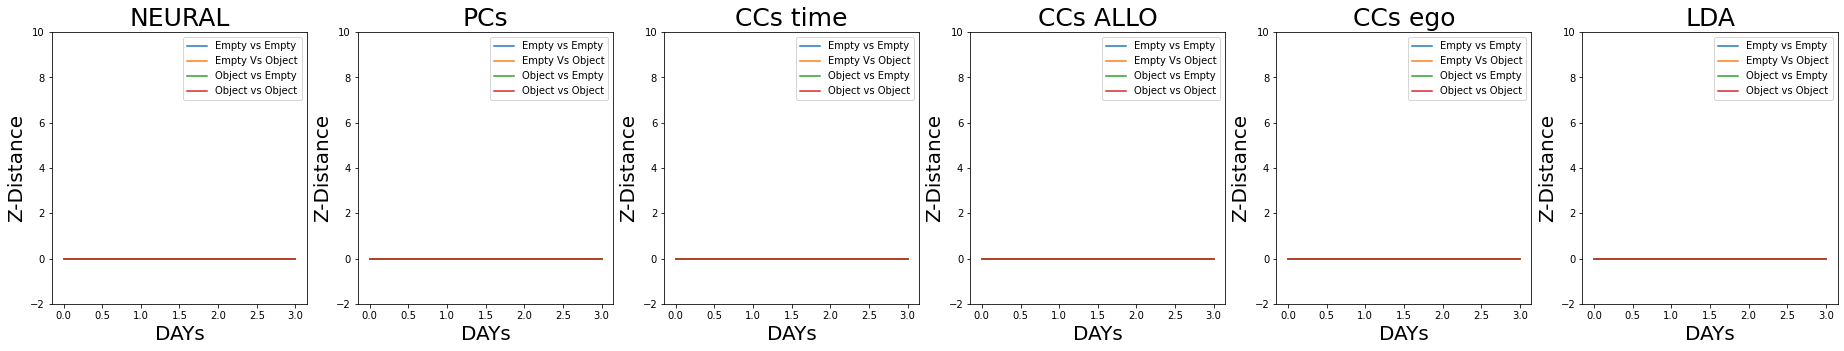

In [23]:
figure, axes = plt.subplots(1,6)

comparisons_legend = ['Empty vs Empty', 'Empty Vs Object', 'Object vs Empty', 'Object vs Object']
transformation_title = ['NEURAL','PCs','CCs time', 'CCs ALLO', 'CCs ego', 'LDA']

for tranformation in range(6):
    axes[tranformation].plot(evolution1[:,tranformation,:])
    axes[tranformation].legend(comparisons_legend)
    axes[tranformation].set_title(transformation_title[tranformation],fontsize = 25)
    axes[tranformation].set_xlabel('DAYs', fontsize = 20)
    axes[tranformation].set_ylim([-2, 10])
    axes[tranformation].set_ylabel('Z-Distance',fontsize = 20)
figure.set_size_inches([32,5])

In [19]:

evolution1 = np.zeros((6,20))
for i in range(20):
    evolution1[0,i]=distance_combination_trial.neural[i][0,1]
    evolution1[1,i]=distance_combination_trial.pca[i][0,1]
    evolution1[2,i]=distance_combination_trial.cca_time[i][0,1]
    evolution1[3,i]=distance_combination_trial.cca_allo[i][0,1]
    evolution1[4,i]=distance_combination_trial.cca_ego[i][0,1]
    evolution1[5,i]=distance_combination_trial.lda[i][0,1]

    
# evolution2 = np.zeros((6,20))
# for i in range(20):
#     evolution2[0,i]=distance_combination_trial.neural[i][0,3]
#     evolution2[1,i]=distance_combination_trial.pca[i][0,3]
#     evolution2[2,i]=distance_combination_trial.cca_time[i][0,3]
#     evolution2[3,i]=distance_combination_trial.cca_allo[i][0,3]
#     evolution2[4,i]=distance_combination_trial.cca_ego[i][0,3]
#     evolution2[5,i]=distance_combination_trial.lda[i][0,3]
    
evolution3 = np.zeros((6,20))
for i in range(20):
    evolution3[0,i]=distance_combination_trial.neural[i][1,2]
    evolution3[1,i]=distance_combination_trial.pca[i][1,2]
    evolution3[2,i]=distance_combination_trial.cca_time[i][1,2]
    evolution3[3,i]=distance_combination_trial.cca_allo[i][1,2]
    evolution3[4,i]=distance_combination_trial.cca_ego[i][1,2]
    evolution3[5,i]=distance_combination_trial.lda[i][1,2]

# evolution4 = np.zeros((6,20))
# for i in range(20):
#     evolution4[0,i]=distance_combination_trial.neural[i][2,3]
#     evolution4[1,i]=distance_combination_trial.pca[i][2,3]
#     evolution4[2,i]=distance_combination_trial.cca_time[i][2,3]
#     evolution4[3,i]=distance_combination_trial.cca_allo[i][2,3]
#     evolution4[4,i]=distance_combination_trial.cca_ego[i][2,3]
#     evolution4[5,i]=distance_combination_trial.lda[i][2,3]
    
    
    
#figure, axes = plt.subplots(1,6)
# for i in range(20):
#     axes[0].plot(distance_exp.neural[i][0,1])
#     axes[1].plot(distance_exp.neural[i][0,2])
#     axes[2].plot(distance_exp.neural[i][0,3])
#     axes[3].plot(distance_exp.neural[i][1,2])
#     axes[4].plot(distance_exp.neural[i][1,3])
#     axes[5].plot(distance_exp.neural[i][2,3])

# for j in range(6):
#     axes[j].set_ylim([-1,10])
# #axes[1].set_ylim([-2,6])

# figure.set_size_inches([25,5])

In [18]:
distance_combination_trial.neural[i].shape

(3, 3)

In [13]:
distance_combination_trial.neural[i]

array([[       nan, 1.49586335, 1.40476515],
       [1.4644032 ,        nan, 0.65308927],
       [1.40177899, 0.6498536 ,        nan]])

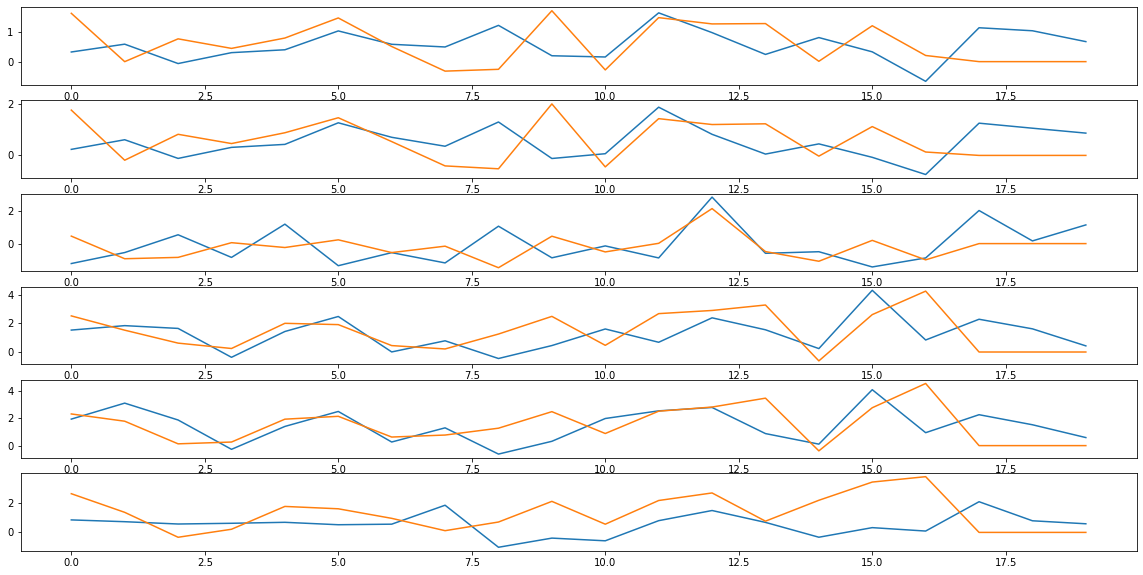

In [26]:
figure, axes = plt.subplots(6,1)
for i in range(6):
    axes[i].plot(evolution1[i,:])
    axes[i].plot(evolution2[i,:])

figure.set_size_inches([20,10])